In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import time

In [2]:
def get_files(file_name):
    point_cloud= []
    with open(file_name) as f:
        lines = f.readlines()
        for line in lines:
            line = line.split()
            point_cloud.append([float(line[0]),float(line[1]),float(line[2])])
    return np.array(point_cloud)  

In [3]:
def plot( Y_PointCloud, Transformed_x):
  ## Plot point clouds
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection='3d')
    y_tr = Y_PointCloud.T
    
    ax.scatter3D(y_tr[0], y_tr[1], y_tr[2],color='r',s=1)
    ax.scatter3D(Transformed_x[0], Transformed_x[1], Transformed_x[2],color='b',s=1)
    ax.view_init(0,0)
    plt.show()

In [4]:
def estimate_correspondences(X,Y,t,R,dmax):
    C =[]
    for i in range (len(X)):
        x = X[i].reshape(3,1)
        translated = (R.dot(x) + t)
        y_T = Y.T
        y = (Y.T - (R.dot(x) + t))
        y = y_T - translated
        y_norm = np.linalg.norm(y,axis=0)
        y_min_index = np.argmin(y_norm)
        if(y_norm[y_min_index]<dmax):
            C.append((i,y_min_index))
    return C

In [5]:
def compute_optimal_rigid_registration(X,Y,C):
    x_centroid= None
    y_centroid = None
    W = np.matrix([[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
    x_sum = np.matrix([0,0,0])
    y_sum = np.matrix([0,0,0])
    K = len(C)
    assert K!=0,"Correspondance List is empty, increase dmax value"
    for i,j in C:
        x_sum = x_sum + X[i]
        y_sum = y_sum + Y[j]
    x_centroid = x_sum/K
    y_centroid = y_sum/K

    for i,j in C:
        x_shifted = X[i] - x_centroid
        y_shifted = np.transpose(Y[j] - y_centroid)
        W += y_shifted.dot(x_shifted)
    W = W/K
    U, S, V_T = np.linalg.svd(W)
    R_optimal = U.dot(V_T)
    t_optimal = y_centroid.T - R_optimal.dot(x_centroid.T)

    return t_optimal,R_optimal

In [6]:
def icp(X_pointcloud,Y_pointcloud,num_ICP_iters,dmax):
    iter_count = 0
    correspondences = None
    R0 =  np.array([[1,0,0],[0,1,0],[0,0,1]])
    t0 = np.array([[0],[0],[0]])
    R = None
    t = None
    while iter_count < num_ICP_iters:
        if(iter_count == 0):
            correspondences = estimate_correspondences(X_pointcloud,Y_pointcloud,t0,R0,dmax)
        else:
            correspondences = estimate_correspondences(X_pointcloud,Y_pointcloud,t,R,dmax)

        t,R = compute_optimal_rigid_registration(X_pointcloud, Y_pointcloud, correspondences)
        iter_count+=1
            
        
    X_Trans = np.transpose(X_pointcloud)
    Y_Trans = np.transpose(Y_pointcloud)
    RMSE_SUM = 0
    RMSE=0
        
    correspondences = estimate_correspondences(X_pointcloud,Y_pointcloud,t,R,dmax)


    for i,j in correspondences:
        x = X_Trans[:,[i]]
        y = Y_Trans[:,[j]]
        y_norm = np.linalg.norm(y - (R.dot(x) + t))
        RMSE_SUM+=y_norm
        
    RMSE = np.sqrt((RMSE_SUM)/len(correspondences))
    return(t,R,correspondences,RMSE)

RMSE : 0.08898488534607683
Rotation matrix : [[ 0.95126601 -0.15043058 -0.26919069]
 [ 0.22323628  0.9381636   0.26460276]
 [ 0.21274056 -0.31180074  0.92602471]]
translation matrix : [[ 0.49661487]
 [-0.29392971]
 [ 0.29645004]]


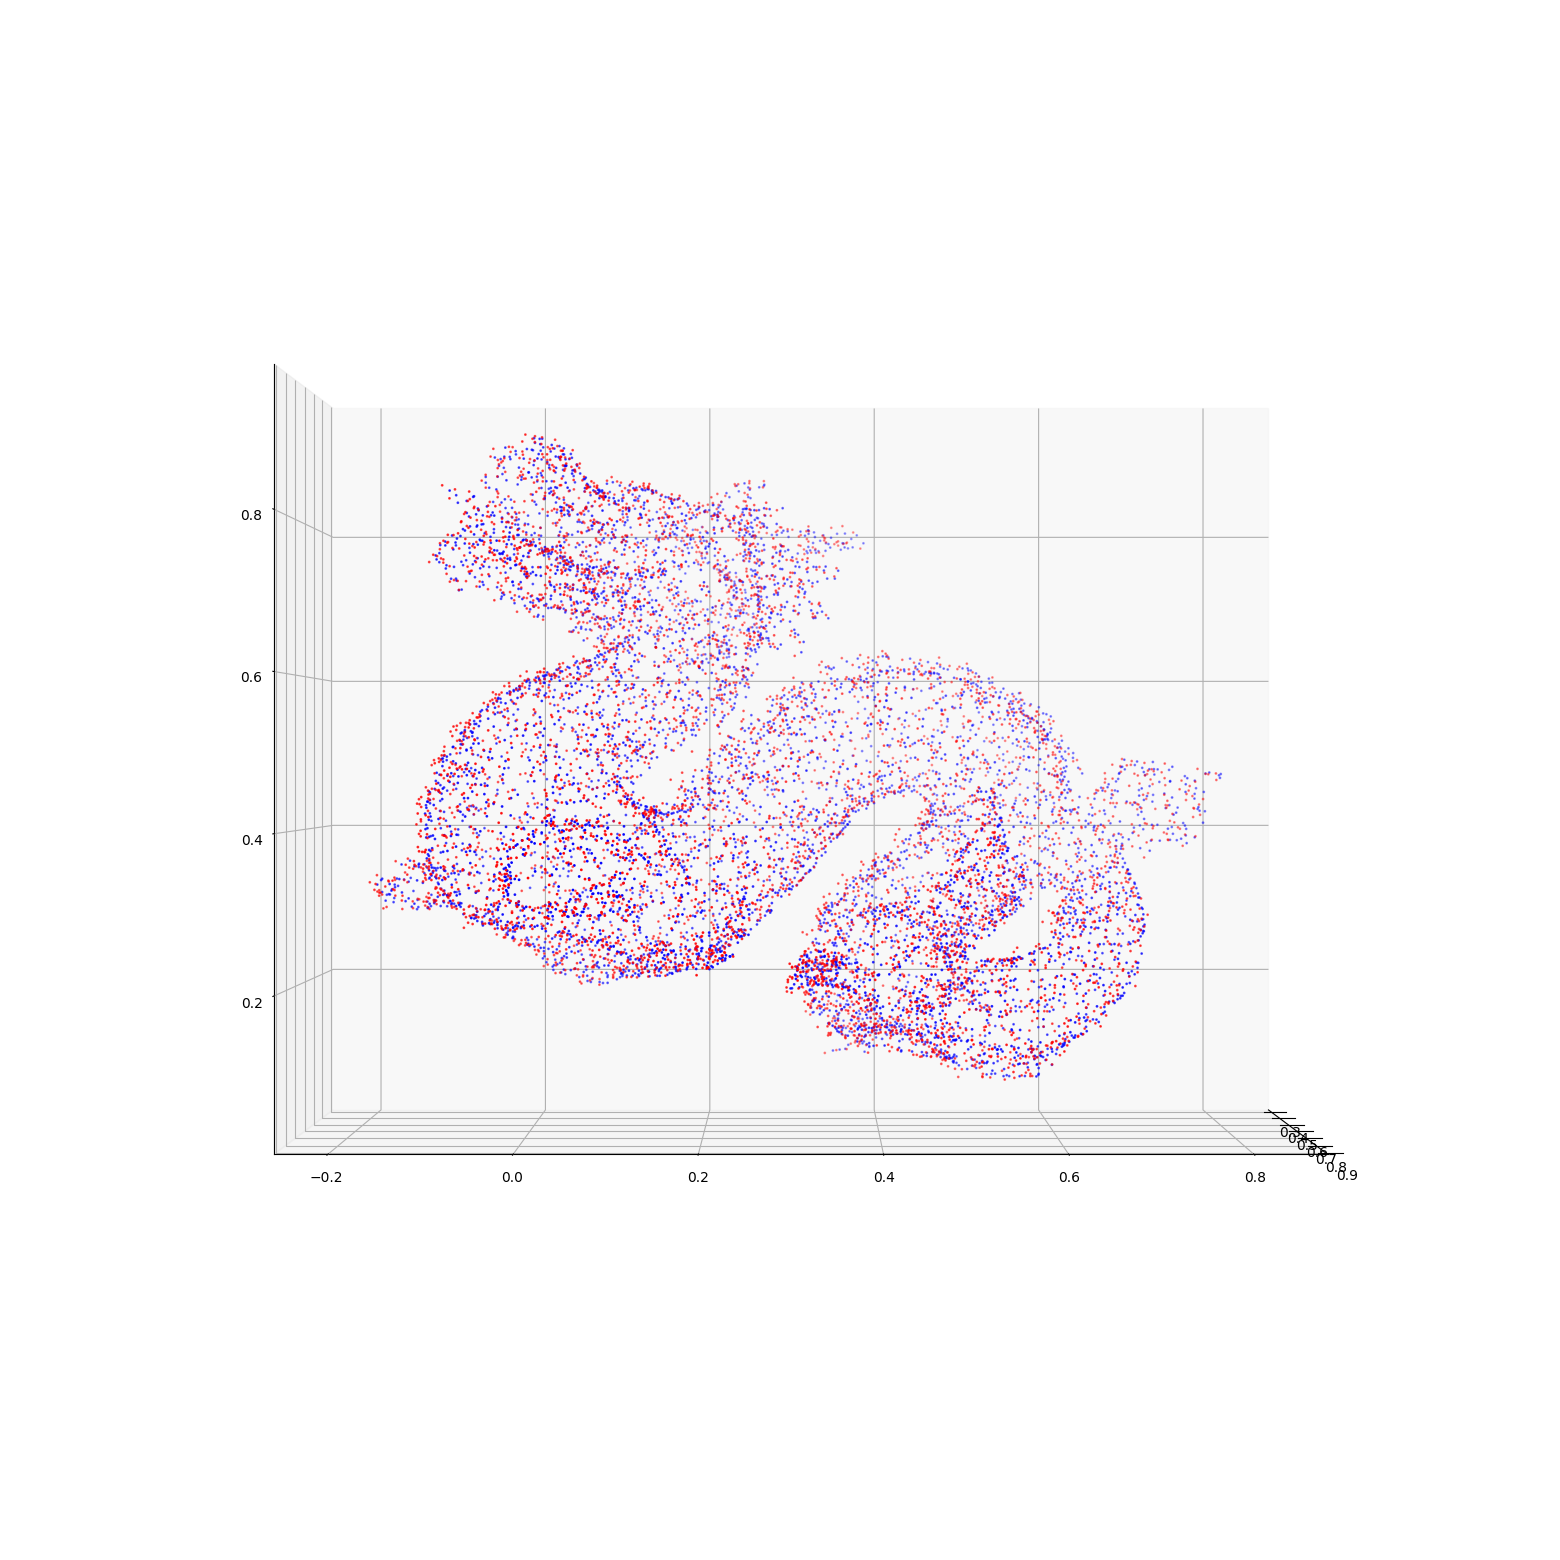

In [7]:
try:
    nIters =30
    max_distance = 0.25

    X_PointCloud = get_files('hw4/pclX.txt')
    Y_PointCloud = get_files('hw4/pclY.txt')

    final_t, final_R, final_C,RMSE = icp(X_PointCloud,Y_PointCloud,nIters,max_distance)
    
    x_tr = X_PointCloud.T
    y_tr = Y_PointCloud.T
    Transformed_x = final_R.dot(x_tr) + final_t

    print(f'RMSE : {RMSE}')  
    print(f'Rotation matrix : {final_R}')
    print(f'translation matrix : {final_t}')


    plot( Y_PointCloud, Transformed_x)

except Exception as e:
    print(e)